## Setup

In [72]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
FORCE_CPU = False
SEED = 2384

HIDDEN_SIZE = 16
SIZE_PER_INPUT = 4
TASK_TRAIN_SIZE = 100000
TASK_TEST_SIZE = 1000
TASK_LR = 0.01
TASK_EPOCHS = 5000
TASK_SCHEDULER_PATIENCE = 1000

SAVE_MODEL = False
LOAD_MODEL = True
MODEL_PATH = "saved_models/hierarchical-equality.pt"

In [74]:
import random
from dataclasses import dataclass
from functools import partial

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import numpy as np

from scipy.ndimage import gaussian_filter1d

import pandas as pd

import matplotlib.pyplot as plt

import plotly.express as px

import networkx as nx

from transformer_lens.hook_points import HookedRootModule, HookPoint
from transformer_lens.utils import to_numpy

from causal_networks.dag import DAGModel, InputNode, EqualityNode

In [75]:
if not FORCE_CPU and torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


## Training the model

In [76]:
@dataclass
class Config:
    input_size: int = 4
    hidden_size: int = 16
    output_size: int = 2

In [77]:
# Create a three layer hooked MLP
class MLP(HookedRootModule):
    def __init__(self, cfg: Config, device=None):
        super().__init__()

        if device is None:
            device = torch.device("cpu")

        self.device = device

        self.cfg = cfg

        self.hook_pre1 = HookPoint()
        self.layer1 = nn.Linear(cfg.input_size, cfg.hidden_size, bias=True, device=device)
        self.hook_mid1 = HookPoint()
        self.hook_pre2 = HookPoint()
        self.layer2 = nn.Linear(cfg.hidden_size, cfg.hidden_size, bias=True, device=device)
        self.hook_mid2 = HookPoint()
        self.hook_pre3 = HookPoint()
        self.layer3 = nn.Linear(cfg.hidden_size, cfg.output_size, bias=True, device=device)
        self.hook_mid3 = HookPoint()
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.hook_pre1(x)
        x = self.hook_mid1(self.layer1(x))
        x = self.relu(x)
        x = self.hook_pre2(x)
        x = self.hook_mid2(self.layer2(x))
        x = self.relu(x)
        x = self.hook_pre3(x)
        x = self.hook_mid3(self.layer3(x))
        return x

In [78]:
# define the model
model = MLP(
    Config(hidden_size=HIDDEN_SIZE, input_size=4 * SIZE_PER_INPUT), device=device
)
model.setup()

print(model)

MLP(
  (hook_pre1): HookPoint()
  (layer1): Linear(in_features=16, out_features=16, bias=True)
  (hook_mid1): HookPoint()
  (hook_pre2): HookPoint()
  (layer2): Linear(in_features=16, out_features=16, bias=True)
  (hook_mid2): HookPoint()
  (hook_pre3): HookPoint()
  (layer3): Linear(in_features=16, out_features=2, bias=True)
  (hook_mid3): HookPoint()
  (relu): ReLU()
)


In [79]:
def generate_grouped_data(n, size_per_input):
    """Generates n data points with 4 balanced groups,
       (w==x, y==z), (w==x, y!=z), (w!=x, y==z), (w!=x, y!=z)
       For the heirarchical equality task""" 
    
    data = np.empty((n, 4, size_per_input))
    labels = np.empty(n)

    quarter = n // 4

    # w==x, y!=z
    data[:quarter, 0] = data[:quarter, 1] = np.random.uniform(-0.5, 0.5, (quarter, size_per_input))
    data[:quarter, 2] = np.random.uniform(-0.5, 0.5, (quarter, size_per_input))
    data[:quarter, 3] = np.random.uniform(-0.5, 0.5, (quarter, size_per_input))
    labels[:quarter] = 0

    # w==x, y==z
    data[quarter:2*quarter, 0] = data[quarter:2*quarter, 1] = np.random.uniform(-0.5, 0.5, (quarter, size_per_input))
    data[quarter:2*quarter, 2] = data[quarter:2*quarter, 3] = np.random.uniform(-0.5, 0.5, (quarter, size_per_input))
    labels[quarter:2*quarter] = 1

    # w!=x, y==z
    data[2*quarter:3*quarter, 0] = np.random.uniform(-0.5, 0.5, (quarter, size_per_input))
    data[2*quarter:3*quarter, 1] = np.random.uniform(-0.5, 0.5, (quarter, size_per_input))
    data[2*quarter:3*quarter, 2] = data[2*quarter:3*quarter, 3] = np.random.uniform(-0.5, 0.5, (quarter, size_per_input))
    labels[2*quarter:3*quarter] = 0

    # w!=x, y!=z
    data[3*quarter:, 0] = np.random.uniform(-0.5, 0.5, (n - 3 * quarter, size_per_input))
    data[3*quarter:, 1] = np.random.uniform(-0.5, 0.5, (n - 3 * quarter, size_per_input))
    data[3*quarter:, 2] = np.random.uniform(-0.5, 0.5, (n - 3 * quarter, size_per_input))
    data[3*quarter:, 3] = np.random.uniform(-0.5, 0.5, (n - 3 * quarter, size_per_input))
    labels[3*quarter:] = 1

    data = data.reshape(n, 4 * size_per_input)

    permute = np.random.permutation(n)
    data = data[permute]
    labels = labels[permute]

    return data, labels

In [80]:
# generate the data
data, labels = generate_grouped_data(TASK_TRAIN_SIZE, SIZE_PER_INPUT)
val_data, val_labels = generate_grouped_data(TASK_TEST_SIZE, SIZE_PER_INPUT)

In [81]:
# train the network

# set the random seed
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

if LOAD_MODEL:

    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))

else:

    # define the loss function and the optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=TASK_LR)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=TASK_SCHEDULER_PATIENCE, verbose=True)

    # convert the data and labels to torch tensors
    data = torch.from_numpy(data).float()
    labels = torch.from_numpy(labels).long()

    data = data.to(device)
    labels = labels.to(device)
    model = model.to(device)

    # train the model
    for epoch in range(TASK_EPOCHS):
        outputs = model(data)
        loss = criterion(outputs, labels)
        
        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step(loss)
        
        if (epoch+1) % 100 == 0:
            print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, TASK_EPOCHS, loss.item()))

# test the model
val_data = torch.from_numpy(val_data).float()
val_labels = torch.from_numpy(val_labels).long()

with torch.no_grad():
    val_data = val_data.to(device)
    val_labels = val_labels.to(device)
    outputs = model(val_data)
    _, predicted = torch.max(outputs.data, 1)

    # compute the accuracy
    total = val_labels.size(0)
    correct = (predicted == val_labels).sum().item()
    print('Accuracy of the network on the test data: {} %'.format(100 * correct / total))

Accuracy of the network on the test data: 100.0 %


In [82]:
if SAVE_MODEL:
    torch.save(model.state_dict(), MODEL_PATH)

## Causal DAGS

In [83]:
dag = DAGModel()

# Define the nodes
dag.add_node("x1", InputNode(), level=0)
dag.add_node("x2", InputNode(), level=0)
dag.add_node("x3", InputNode(), level=0)
dag.add_node("x4", InputNode(), level=0)
dag.add_node("b1", EqualityNode(), level=1)
dag.add_node("b2", EqualityNode(), level=1)
dag.add_node("y", EqualityNode(), level=2)

# Define the edges
edges = [
    ("x1", "b1"),
    ("x2", "b1"),
    ("x3", "b2"),
    ("x4", "b2"),
    ("b1", "y"),
    ("b2", "y"),
]
for edge in edges:
    dag.add_edge(*edge)

dag.set_visualization_layout(
    partial(nx.multipartite_layout, subset_key="level", align="horizontal", scale=-1)
)

print(dag)

DAGModel(
  (x1): InputNode()
  (hook_x1): HookPoint()
  (x2): InputNode()
  (hook_x2): HookPoint()
  (x3): InputNode()
  (hook_x3): HookPoint()
  (x4): InputNode()
  (hook_x4): HookPoint()
  (b1): EqualityNode()
  (hook_b1): HookPoint()
  (b2): EqualityNode()
  (hook_b2): HookPoint()
  (y): EqualityNode()
  (hook_y): HookPoint()
)


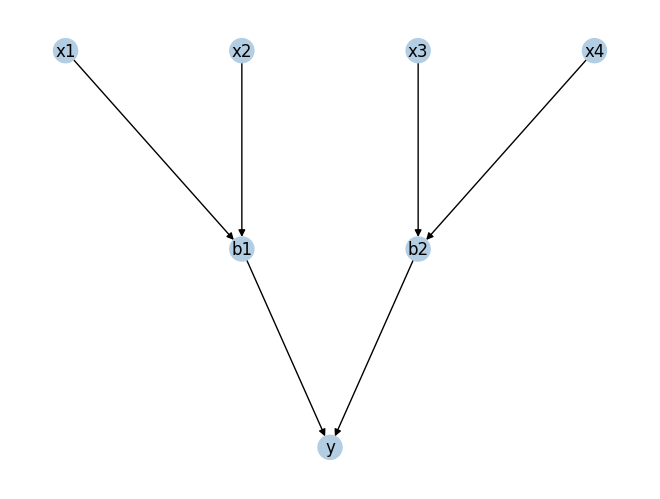

                        Node Information                        
┏━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Node ┃ Module         ┃ Value                                ┃
┡━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ x1   │ InputNode()    │ tensor([0, 0, 0, 0])                 │
│ x2   │ InputNode()    │ tensor([0, 1, 1, 0])                 │
│ x3   │ InputNode()    │ tensor([0, 0, 0, 0])                 │
│ x4   │ InputNode()    │ tensor([0, 0, 1, 1])                 │
│ b1   │ EqualityNode() │ tensor([ True, False, False,  True]) │
│ b2   │ EqualityNode() │ tensor([ True,  True, False, False]) │
│ y    │ EqualityNode() │ tensor([ True, False,  True, False]) │
└──────┴────────────────┴──────────────────────────────────────┘

In [84]:
dag(
    dict(
        x1=torch.tensor([0, 0, 0, 0]),
        x2=torch.tensor([0, 1, 1, 0]),
        x3=torch.tensor([0, 0, 0, 0]),
        x4=torch.tensor([0, 0, 1, 1]),
    )
)

dag.visualize(display_node_values=True)

In [85]:
def tensor_to_dict(tensor):
    return dict(x1=tensor[..., 0], x2=tensor[..., 1], x3=tensor[..., 2], x4=tensor[..., 3])

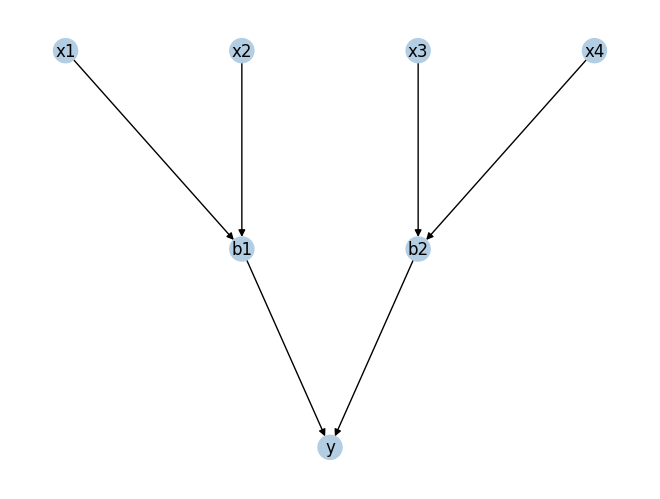

                    Node Information                     
┏━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Node ┃ Module         ┃ Value                         ┃
┡━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ x1   │ InputNode()    │ tensor([1., 1., 1.])          │
│ x2   │ InputNode()    │ tensor([1., 1., 1.])          │
│ x3   │ InputNode()    │ tensor([1., 1., 1.])          │
│ x4   │ InputNode()    │ tensor([1., 1., 1.])          │
│ b1   │ EqualityNode() │ tensor([False, False,  True]) │
│ b2   │ EqualityNode() │ tensor([False,  True,  True]) │
│ y    │ EqualityNode() │ tensor([ True, False,  True]) │
└──────┴────────────────┴───────────────────────────────┘

In [86]:
dag.run_interchange_intervention(
    tensor_to_dict(torch.ones(3, 4)),
    tensor_to_dict(torch.rand(3, 2, 4)),
    dict(
        b1=torch.tensor([[True, False], [True, False], [False, False],]),
        b2=torch.tensor([[False, True], [False, False], [False, False],]),
    ),
)
dag.visualize(display_node_values=True)